In [3]:
import torch
from torch_geometric.data import Data

import torch.nn as nn
import torch_geometric.nn as pyg_nn

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

import numpy as np

In [6]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NVIDIA GeForce GTX 1650
Using device: cuda


In [7]:

# Beam discretization
num_nodes = 100  # Number of points along the beam
x = torch.linspace(0, 1, num_nodes).view(-1, 1)  # Normalized positions

# Define edges (line graph)
edge_index = torch.tensor([
    [i for i in range(num_nodes - 1)],  # Source nodes
    [i + 1 for i in range(num_nodes - 1)]  # Target nodes
], dtype=torch.long)

# Make the graph bidirectional (for better learning)
edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

# Create graph data
beam_graph = Data(x=x, edge_index=edge_index)

print(beam_graph)


Data(x=[100, 1], edge_index=[2, 198])


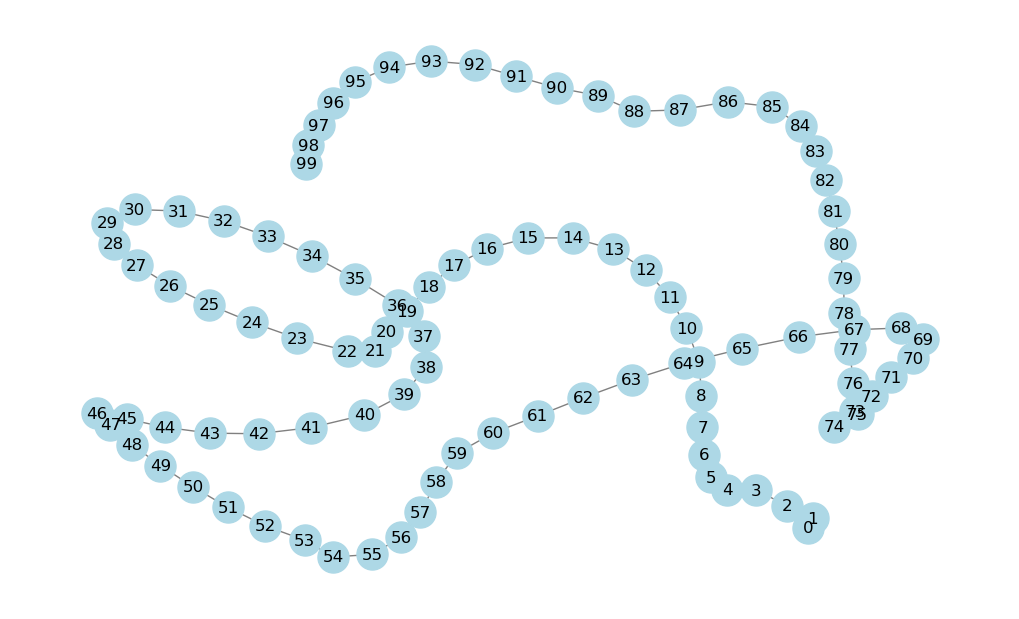

In [8]:

# Convert PyG graph to NetworkX format
G = to_networkx(beam_graph, to_undirected=True)  # Make edges bidirectional

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500)
plt.show()


In [19]:
class BeamGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = pyg_nn.GCNConv(1, 32)
        self.conv2 = pyg_nn.GCNConv(32, 32)
        self.conv3 = pyg_nn.GCNConv(32, 32)
        self.conv4 = pyg_nn.GCNConv(32, 32)
        self.conv5 = pyg_nn.GCNConv(32, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.tanh(self.conv1(x, edge_index))
        x = torch.tanh(self.conv2(x, edge_index))
        x = torch.tanh(self.conv3(x, edge_index))
        x = torch.tanh(self.conv4(x, edge_index))
        x = self.conv5(x, edge_index)
        return x

In [20]:
E = 70e9
I = 0.1**4 / 12 # Square cross section with lenght 0.1m
EI = E * I
print(EI)
L = 3.0
Q = -20000.0
q0 = np.abs(Q)
q = Q / q0
print(q)

583333.3333333335
-1.0


In [37]:
model = BeamGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
beam_graph.x.requires_grad = True

In [38]:
def model_value(graph):
    u = model(graph)
    return u

In [39]:
def loss_func(data):
    u = model_value(data)
    u_x = torch.autograd.grad(u, data.x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_2x = torch.autograd.grad(u_x, data.x, torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    u_3x = torch.autograd.grad(u_2x, data.x, torch.ones_like(u_2x), create_graph=True, retain_graph=True)[0]
    u_4x = torch.autograd.grad(u_3x, data.x, torch.ones_like(u_3x), create_graph=True, retain_graph=True)[0]

    fixed_mask = (data.x == 0)
    free_mask = (data.x == 1)

    bc_loss = u[fixed_mask]**2 + u_x[fixed_mask]**2
    bc_loss += u_3x[free_mask]**2 + u_4x[free_mask]**2

    pde_loss = torch.mean(torch.pow(u_4x - q, 2))

    return pde_loss, bc_loss


In [11]:
def pde_loss(data):
    u, m = model_value(data)
    u_x = torch.autograd.grad(u, data.x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_2x = torch.autograd.grad(u_x, data.x, torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]

    m_x = torch.autograd.grad(m, data.x, torch.ones_like(m), create_graph=True, retain_graph=True)[0]
    m_2x = torch.autograd.grad(m_x, data.x, torch.ones_like(m_x), create_graph=True, retain_graph=True)[0]

    loss1 = m_2x + q
    loss2= u_2x + m

    return loss1, loss2

In [40]:
def train(epochs=1000):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        pde_loss, bc_loss = loss_func(beam_graph)
        loss = pde_loss + bc_loss
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {'{:e}'.format(loss.item())}")
            print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")

In [41]:

train(2000)

Epoch: 0, Loss: 1.771607e+00
PDE: 1.760272e+00, BC: 1.133539e-02
Epoch: 100, Loss: 1.733379e-01
PDE: 1.110687e-01, BC: 6.226923e-02
Epoch: 200, Loss: 1.099112e-01
PDE: 8.450186e-02, BC: 2.540937e-02
Epoch: 300, Loss: 9.117941e-02
PDE: 7.686368e-02, BC: 1.431572e-02
Epoch: 400, Loss: 2.227783e-01
PDE: 1.649103e-01, BC: 5.786800e-02
Epoch: 500, Loss: 1.986894e-01
PDE: 9.364750e-02, BC: 1.050419e-01
Epoch: 600, Loss: 1.947569e-01
PDE: 1.190639e-01, BC: 7.569293e-02
Epoch: 700, Loss: 1.923924e-01
PDE: 1.221770e-01, BC: 7.021543e-02
Epoch: 800, Loss: 1.994106e-01
PDE: 9.519186e-02, BC: 1.042188e-01
Epoch: 900, Loss: 1.530356e-01
PDE: 1.024525e-01, BC: 5.058303e-02
Epoch: 1000, Loss: 1.567957e-01
PDE: 1.007092e-01, BC: 5.608641e-02
Epoch: 1100, Loss: 1.283225e-01
PDE: 8.542280e-02, BC: 4.289974e-02
Epoch: 1200, Loss: 8.937154e-02
PDE: 8.149793e-02, BC: 7.873607e-03
Epoch: 1300, Loss: 7.168861e-02
PDE: 6.730335e-02, BC: 4.385259e-03
Epoch: 1400, Loss: 7.907529e-02
PDE: 7.626270e-02, BC: 2.812

In [33]:
q1 = lambda x: Q / (24*EI) * (x**4 - 4*L*x**3 + 6*L**2*x**2) # Fixed, free, constant q

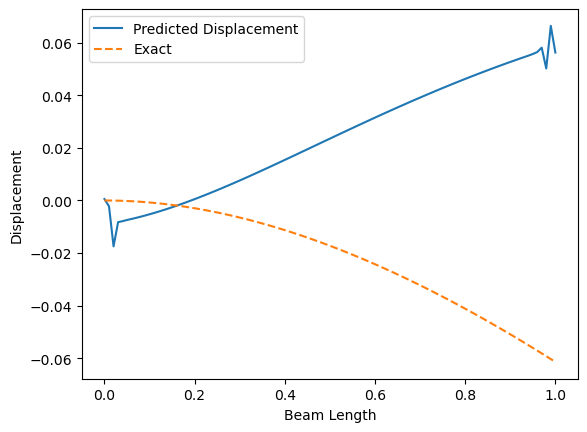

In [35]:
import matplotlib.pyplot as plt

um = model_value(beam_graph)
u = um.detach().cpu().numpy()
x1 = x.detach().cpu().numpy()
u_pred = (L**4 * q0 / EI) * u

exact = q1(x1)

plt.plot(x1, u, label="Predicted Displacement")
plt.plot(x1, exact, label="Exact", linestyle="dashed")
plt.xlabel("Beam Length")
plt.ylabel("Displacement")
plt.legend()
plt.show()


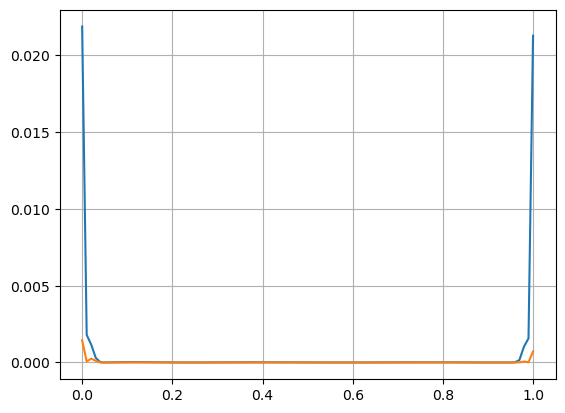

In [17]:
l1, l2 = pde_loss(beam_graph)
y1 = l1.detach().cpu().numpy()
y2 = l2.detach().cpu().numpy()

plt.plot(x1, y1**2)
plt.plot(x1, y2**2)
plt.grid()
plt.show()